

# Deep Dream algorithm and Adversarial example // Playing with the gradient !



In this notebook, we shall be looking at two subjects :

- A way to visualise what networks are learning : the Deep Dream algorithm
- Adversarial examples

At the heart of these two applications is the calculation of the gradient of a loss function with respect to the image itself (instead of respect to the weights). The loss function will be defined depending on the application at hand.

We shall use a pre-trained, well-known pretrained network. The lab has been designed for either VGG16 or inceptionv3. 

We can easily access certain well-known networks with the Tensorflow programming framework. There are useful predefined functions which allow us to load the weights, view the architecture etc. of the networks.

https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py

https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py

https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py


First, let's load the necessary packages.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Input
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

print(tf.keras.__version__)


2.7.0


Now, let's load one of the most famous networks, VGG16 or inceptionv3 (you choose), and view it's architecture with the summary() function.

In [ ]:

model_name = 'vgg16'#'inceptionv3'#

if model_name == 'inceptionv3':
	model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
elif model_name == 'vgg16':
	model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

model.summary()


58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Now we're retrieving the weights of the network 
  

In [ ]:
def retrieve_weights(model):
    weight_list = []
    for lay in model.layers:
      if lay.get_weights() != []:
        weight_list.append(lay.get_weights()[0])
    return weight_list

Now, we're visualizing a single channel of a filter 

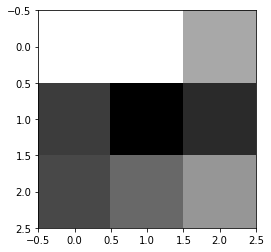

In [ ]:
weight_list = retrieve_weights(model)
curr_weight = weight_list[2]
curr_weight.shape
plt.imshow(curr_weight[:,:,0,1],cmap="gray")

In [ ]:
curr_weight[:,:,0,1]

array([[ 0.03781697,  0.03759558,  0.01217471],
       [-0.01912256, -0.03680309, -0.02436409],
       [-0.01577048, -0.00621745,  0.00700018]], dtype=float32)

As you can probably see, this visualisation is not of much use : we cannot really tell what is going on in the network. For this, let's turn to another approach : Deep Dream !

## 2. Deep Dream

We now proceed to carry out the Deep Dream algorithm. The idea of the Deep Dream algorithm is to find an image which maximises the response of a network at a certain layer : $\textbf{this should help us understand what the network is learning}$. This can be done with an iterative algorithm, by simply carrying out gradient $\textbf{ascension}$. We start with an input image and iteratively add the gradient of the average response of the features which interest us. A pseudo-code for this would be :

- img = img_in
- for i=1:n_iters
    - img = img + grad_step $\nabla_{img} \mathcal{L}$,
    
where $\mathcal{L}$ is a function of the responses which interest us (you need to define this). In this part of the lab, we shall use the average response.

Let's first define a function to preprocess the image. This is needed to put the image in the correct format for the VGG16 or inceptionv3 networks. We also create a function to invert this process. 

In [ ]:
def format_image(img_file,model_name):
	"""
	This function reads and formats an image so that it can be fed to the VGG16 or inceptionv3 networks
	
	Parameters
	----------
	img_file : image file name
	
	Returns
	-------
	img_out_model : the correctly formatted image for VGG16 or inceptionv3 networks
	img : the image as read by the load_img function of keras.preprocessing.image
	"""
	# read image
	img = load_img(img_file)
	# convert image to an array
	img_out = img_to_array(img)
	# preprocess the image to put in the correct format for use with the VGG16/inceptionv3 network trained on imagenet
	
	if model_name == 'inceptionv3':
		#https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input
		#The inputs pixel values are scaled between -1 and 1, sample-wise.
		img_out_model = tf.keras.applications.inception_v3.preprocess_input(img_out)
	elif model_name == 'vgg16':
		#https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input
		#The images are converted from RGB to BGR,
		#then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
		img_out_model = tf.keras.applications.vgg16.preprocess_input(img_out)
	# add a dimension at the beginning, coresponding to the batch dimension
	img_out_model = np.expand_dims(img_out_model, axis=0)
	return img_out_model, img

def unformat_image(img_in,model_name):
	"""
	This function inverts the preprocessing applied to images for use in the VGG16/inceptionv3 network
	
	Parameters
	----------
	img_file : formatted image of shape (batch_size,m,n,3)
	
	Returns
	-------
	img_out : a m-by-n-by-3 array, representing an image that can be written to an image file
	"""
	#get rid of batch dimension
	img_out=np.squeeze(img_in)

	
	if(model_name == 'inceptionv3'):
		#clamp image to the range [0,255] and cast to uint8
		img_out = 255*(img_out + 1.0)/2.0
	if (model_name == 'vgg16'):
		#https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input
		#The images are converted from RGB to BGR,
		#then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
		#remove offsets added by the VGG16 preprocessing
		img_out[:, :, 0] += 103.939
		img_out[:, :, 1] += 116.779
		img_out[:, :, 2] += 123.68
		#invert the order of the colours : BGR -> RGB
		img_out = img_out[:, :, ::-1]
		#img_out = 255*(img_out + 1.0)/2.0
	
	img_out = np.clip(img_out, 0, 255).astype('uint8')
	return img_out

Now, we load the image. At the same time, we create a backend Tensor which has the correct format for the network.

--2021-11-11 20:58:01--  https://perso.telecom-paristech.fr/anewson/doc/images/got.jpg
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.2.165, 2001:660:330f:2::a5
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.2.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29707 (29K) [image/jpeg]
Saving to: ‘got.jpg’

got.jpg             100%[===================>]  29.01K  --.-KB/s    in 0s      

2021-11-11 20:58:01 (325 MB/s) - ‘got.jpg’ saved [29707/29707]



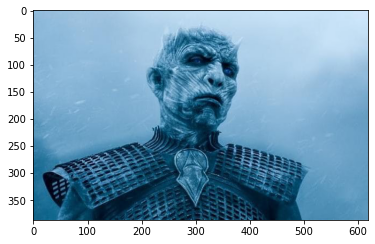

In [ ]:
using_colab = True

#load image
if (using_colab == True):
    !wget "https://www.journaldugeek.com/content/uploads/2020/02/409755-r-1280-720-f-jpg-q-x-xxyxx.jpg"
    img_in,img_visu = format_image('got.jpg',model_name)
else:
    img_in,img_visu = format_image('images/got.jpg',model_name)
#show the input image
plt.imshow(img_visu)
plt.show()

Now, we define the loss that we wish to maximise. This can be anything we wish, but a common loss is simply the average response of a certain channel of a certain layer. Since these responses are all positive, due to the non-linearities used, we can safely take the average as a loss function to maximise.

We are going to use the responses of different layers depending on whether we use inceptionv3 or vgg16. 

In [ ]:

if(model_name == 'inceptionv3'): 
	layer_names = ['mixed3', 'mixed5']
elif (model_name == 'vgg16'):
	layer_names = ['block5_conv2', 'block5_conv3']
layers = [model.get_layer(name).output for name in layer_names]
# create a model which outputs the layer which interests us
img_backend = model.input
deepdream_model = tf.keras.Model(inputs=img_backend, outputs=layers)
print(deepdream_model)


Now, we create the deep dream loss. 


In [ ]:
def deep_dream_loss(model_in,img_in):
	activation = model_in(img_in) 
	if len(activation) == 1:
		activation = [activation]

	losses = []
	for act in activation:
		loss = tf.math.reduce_mean(act) 
		losses.append(loss)
	total_loss = tf.math.reduce_sum(losses)

	return total_loss

Now, we create a function to carry out one step of the gradient __ascent__. For this, we need to calculate the gradient of the loss with respect to the input image. 

This is done with the following syntax. For this example, we consider that ```x``` is the variable, and ```my_loss_function``` is the function which we want to take the derivative of.

```
with tf.GradientTape() as tape:
    tape.watch(x)
    loss = my_loss_function(x)
grads = tape.gradient(loss,x)
```

Next, we use a little trick. Indeed, it may be the case that the gradients are far too small or far too large for updating, meaning that the updates do nothing or destroy the image. To avoid this, we normalise the gradients, such that the standard deviation is 1. 
Finally, to make sure there are no division problems, we also add a small constant $\epsilon $to the standard deviation. In other words :

- $\nabla = \frac{\nabla}{std(\nabla) + \epsilon}$


In [ ]:
def gradient_step(model_in, img_in, step_size, model_name):
  with tf.GradientTape() as tape:
      tape.watch(img_in)
      loss = deep_dream_loss(model_in,img_in)
  grads = tape.gradient(loss,img_in)

  eps = 1e-8

  grads = grads / ( tf.math.reduce_std(grads) + eps)
  img_in = img_in + step_size * grads

  if (model_name == 'inceptionv3'):
    img_in = tf.clip_by_value(img_in, -1, 1) # special case for inceptionv3
  return img_in, loss


We are now ready to carry out the Deep Dream algorithm using gradient ascent, yipee ! 

.

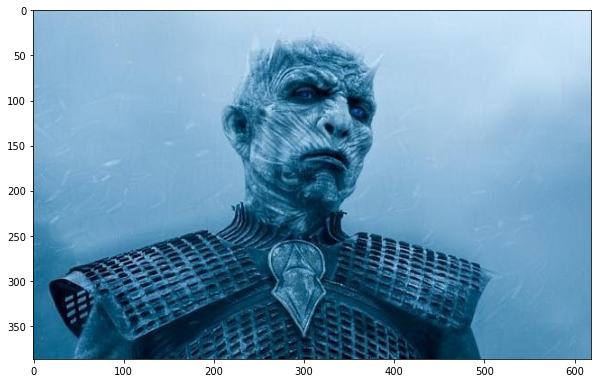

.

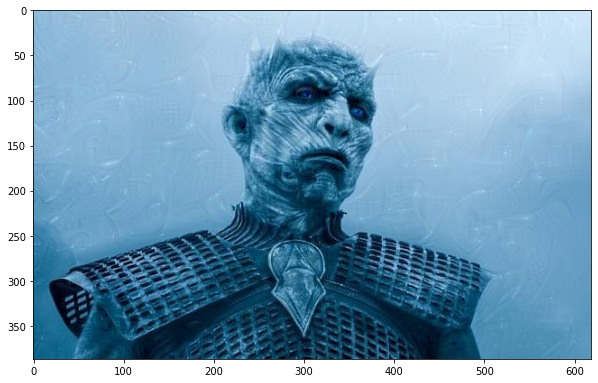

.

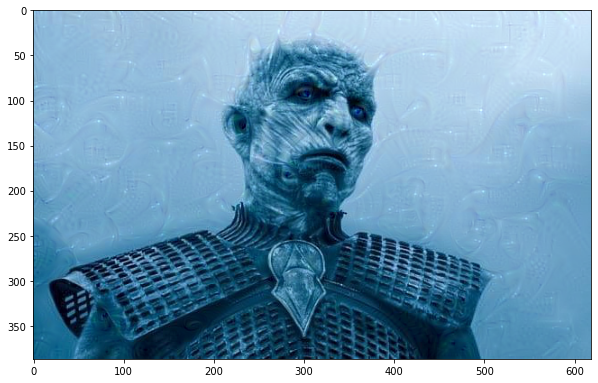

.

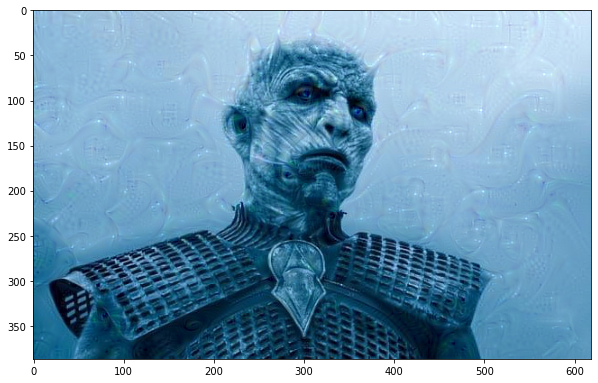

.

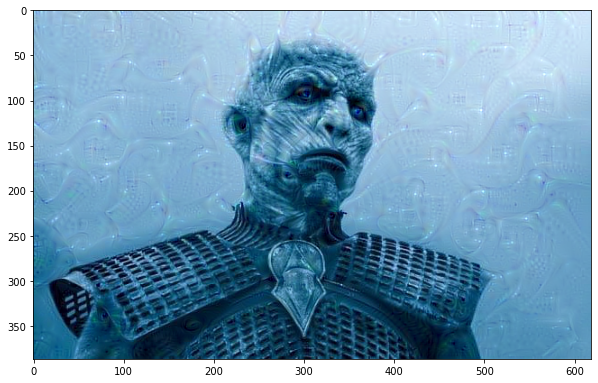

.

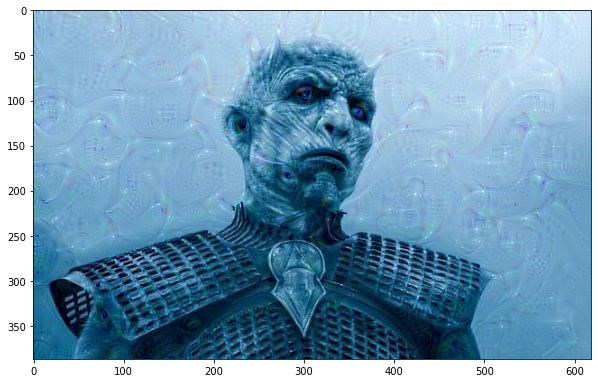

.

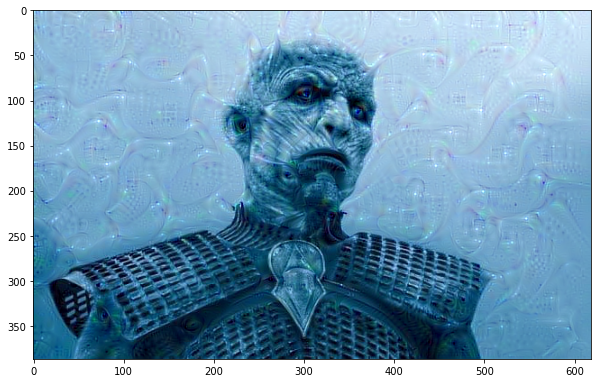

.

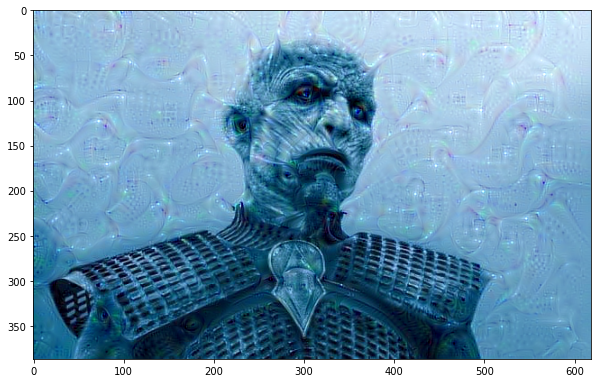

In [ ]:
# first, reload image to make sure that we are not starting from a previous initialisation
if (using_colab == True):
	#!wget 'https://perso.telecom-paristech.fr/anewson/doc/images/got.jpg'
	img_in,_ = format_image('got.jpg',model_name)
else:
	img_in,_ = format_image('images/got.jpg',model_name)

img_in = tf.convert_to_tensor(img_in)
if (model_name == 'inceptionv3'):
	step = 0.1 # Gradient ascent step size
elif (model_name == 'vgg16'):
	step = 0.5 # Gradient ascent step size
n_iterations = 40  # Number of gradient ascent steps

for ii in range(0,n_iterations):
	img_in, loss = gradient_step(deepdream_model,img_in,step,model_name)
	
	if (ii%5==0):
		print(".", end='')
		img_out = unformat_image(np.copy(img_in),model_name)
		plt.figure(num=None, figsize=(10, 8))
		plt.imshow(img_out)
		plt.show()
    #plt.imsave('img_out_'+str(ii).zfill(3)+'.png',img_out)

You can try different layers and switch between the two models and see what the results are !

## 3. Adversarial examples

In this part, we will explore the interesting case of adversarial examples. Adversarial examples are images which have been perturbed in a manner which __makes the network misclassify the image__.

There are many ways to do this, however we can use a similar approach to the one used above, that is to say, we will use a gradient maximisation approach. This consists in iteratively adding the gradient of the loss with respect to the image, to the current image, in order to get a misclassified image.


In [ ]:
model_name = 'vgg16'#'inceptionv3'#
# load model, including last (classification layer)
if model_name == 'inceptionv3':
	model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
elif model_name == 'vgg16':
	model = tf.keras.applications.VGG16(include_top=True, weights='imagenet')

# display architecture
model.summary()

553476096/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

Y
We are nw going to take an image of a cat and try to misclassify it.  
NOTE 

In the previous code, we were not interested in the dense layers, so the input image could be of __any size__ (there were only convolutional and maxpool layers). Now, since we are using the fully connected layers, we need to make sure the input is of the correct size for the images used in each network. For this, we redefine the format_image function to force the image to a certain size, depending on the network.

In [ ]:
def format_image_classif(img_file,model_name):
    """
    This function reads and formats an image so that it can be fed to the VGG16 or InceptionV3 network.
    In this case, we wish to force the image size to a certain shape, since we want to use the image for
    classification
    
    Parameters
    ----------
    img_file : image file name
    img_width : the target image width
    img_height : he target image height
    
    Returns
    -------
    img_out_model : the correctly formatted image for VGG16 or InceptionV3
    img : the image as read by the load_img function of keras.preprocessing.image
    """
    if model_name == 'inceptionv3':
      img_width = 299
      img_height = 299
    elif model_name == 'vgg16':
      img_width = 224
      img_height = 224
    # read image. Force the image size to a certain shape (uses a resize of the pillow package)
    img = load_img(img_file,target_size=(img_height,img_width))
    # convert image to an array
    img_out = img_to_array(img)

    if model_name == 'inceptionv3':
      #https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input
      #The inputs pixel values are scaled between -1 and 1, sample-wise.
      img_out_model = tf.keras.applications.inception_v3.preprocess_input(img_out)
    elif model_name == 'vgg16':
      #https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input
      #The images are converted from RGB to BGR,
      #then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
      img_out_model = tf.keras.applications.vgg16.preprocess_input(img_out)
    # add a dimension at the beginning, coresponding to the batch dimension
    img_out_model = np.expand_dims(img_out_model, axis=0)
    return img_out_model, img

--2021-11-11 20:59:03--  https://perso.telecom-paristech.fr/anewson/doc/images/cat_small.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.2.165, 2001:660:330f:2::a5
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.2.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160840 (157K) [image/png]
Saving to: ‘cat_small.png’

cat_small.png       100%[===================>] 157.07K  --.-KB/s    in 0.01s   

2021-11-11 20:59:03 (11.4 MB/s) - ‘cat_small.png’ saved [160840/160840]

(1, 224, 224, 3)


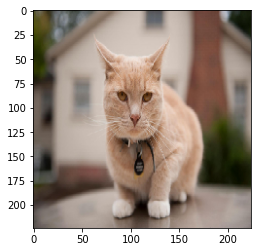

In [ ]:
if (using_colab == True):
    !wget "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg"
    img_in,img_visu = format_image_classif('cat_small.png',model_name)
else:
    img_in,img_visu = format_image_classif('images/cat_small.png',model_name)

plt.imshow(img_visu)
print(img_in.shape)

Now, we need to retrieve the last layer of the VGG or inceptionv3 networks. 

In [ ]:
if(model_name == 'inceptionv3'): 
	layer_names = []
	for lay in model.layers:
		if lay.get_weights() != [] :
			layer_names.append(lay.name)
	
	
elif (model_name == 'vgg16'):
	layer_names = []
	for lay in model.layers:
		if lay.get_weights() != [] :
			layer_names.append(lay.name)
layers = [model.get_layer(name).output for name in layer_names]
# create a model which outputs the layer which interests us
img_backend = model.input
adversarial_model = tf.keras.Model(inputs=img_backend, outputs=layers)


We are going to try to force the image to recognise a 'reflex_camera'. This is number 759 of the imagenet classes. You can use any one you like in fact (apart from ones linked to cats, obviously). To see the list of classes :

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a


In [ ]:
target_class = 759
y_predicted = model.predict(img_in) 
true_class = np.zeros((1,y_predicted.shape[1]))
true_class_ind = 281 
true_class[0,true_class_ind] = 1 

if model_name == 'inceptionv3':
  # print the top prediction
  print("True class : ",tf.keras.applications.inception_v3.decode_predictions(true_class, top=1)[0])
  # print the top 5 predicted classes, with the prediction probability
  y_predicted_decoded = tf.keras.applications.vgg16.decode_predictions(model.predict(img_in))[0] 
elif model_name == 'vgg16':
  print("True class : ",tf.keras.applications.vgg16.decode_predictions(true_class, top=1)[0])
  y_predicted_decoded = tf.keras.applications.vgg16.decode_predictions(model.predict(img_in))[0] 
print(y_predicted_decoded)


49152/35363 [=========================================] - 0s 0us/step
True class :  [('n02123045', 'tabby', 1.0)]
[('n02124075', 'Egyptian_cat', 0.66962117), ('n02123045', 'tabby', 0.122342765), ('n02123159', 'tiger_cat', 0.09129731), ('n02127052', 'lynx', 0.032521654), ('n04141975', 'scale', 0.0050705145)]


We must redefine the loss function for the adversarial model. 

In [ ]:
def adversarial_loss(model_in,img_in,target_class):
	activation = model_in(img_in) 

	total_loss = activation[-1][0,target_class]    

	return total_loss

def adversarial_gradient_step(model_in, img_in, step_size, model_name,target_class):
  with tf.GradientTape() as tape:
      tape.watch(img_in)
      loss = adversarial_loss(model_in,img_in,target_class)
  grads = tape.gradient(loss,img_in)

  eps = 1e-8

  grads = grads / ( tf.math.reduce_std(grads) + eps )
  # grad_step = 0.01
  img_in = img_in + step_size * grads  

  if (model_name == 'inceptionv3'):
    img_in = tf.clip_by_value(img_in, -1, 1) # special case for inceptionv3
  return img_in, loss

We are now ready to perturb the image such that we misclassify it. Youhoo !

--2021-11-11 20:59:06--  https://perso.telecom-paristech.fr/anewson/doc/images/cat_small.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.2.165, 2001:660:330f:2::a5
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.2.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160840 (157K) [image/png]
Saving to: ‘cat_small.png.1’

cat_small.png.1     100%[===================>] 157.07K  --.-KB/s    in 0.01s   

2021-11-11 20:59:06 (12.0 MB/s) - ‘cat_small.png.1’ saved [160840/160840]

[('n02124075', 'Egyptian_cat', 0.6672454)]
[('n02124075', 'Egyptian_cat', 0.65284306)]
[('n02124075', 'Egyptian_cat', 0.6314646)]
[('n02124075', 'Egyptian_cat', 0.5961681)]
[('n02124075', 'Egyptian_cat', 0.51518846)]
[('n02124075', 'Egyptian_cat', 0.30882165)]
[('n02124075', 'Egyptian_cat', 0.07295926)]
[('n03657121', 'lens_cap', 0.08723982)]
[('n04069434', 'reflex_camera', 0.43626276)]
[('n04069434', 'reflex_camera', 0.9022461)]

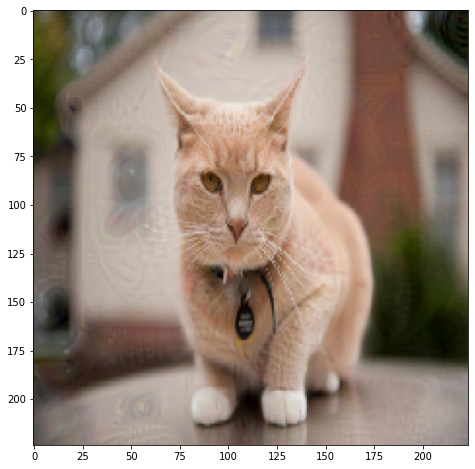

In [ ]:
#reload image, to make sure we are not starting from previous point
if (using_colab == True):
    !wget "https://perso.telecom-paristech.fr/anewson/doc/images/cat_small.png"
    img_in,img_visu = format_image_classif('cat_small.png',model_name)
else:
    img_in,img_visu = format_image_classif('images/cat_small.png',model_name)

#img_in = 10*np.random.randn(1,img_in.shape[1],img_in.shape[2],img_in.shape[3])
#parameters
img_in = tf.convert_to_tensor(img_in)
if (model_name == 'inceptionv3'):
  step = 0.01  # Gradient ascent step size
elif(model_name == 'vgg16'):
  step = 0.1  # Gradient ascent step size
n_iterations = 100  # Number of gradient ascent steps
for ii in range(0,n_iterations):
    img_in, loss = adversarial_gradient_step(adversarial_model,img_in,step,model_name,target_class) 
    if (ii%5==0):
        img_show = unformat_image(np.copy(img_in),model_name)
        plt.imsave('img_out_'+str(ii).zfill(3)+'.png',img_show)
        #predict current model to see evolution of top classification
        y_predicted = model.predict(img_in)
        if (model_name == 'inceptionv3'):
          print(tf.keras.applications.inception_v3.decode_predictions(y_predicted, top=1)[0])
        if (model_name == 'vgg16'):
          print(tf.keras.applications.vgg16.decode_predictions(y_predicted, top=1)[0])
print('End of optimisation')
# finally, display misclassified image
img_show = unformat_image(np.copy(img_in),model_name)
plt.figure(num=None, figsize=(10, 8))
plt.imshow(img_show)
#show the final top 5 classes
y_predicted = model.predict(img_in)
if (model_name == 'inceptionv3'):
  print(tf.keras.applications.inception_v3.decode_predictions(y_predicted, top=5)[0])
if (model_name == 'vgg16'):
  print(tf.keras.applications.vgg16.decode_predictions(y_predicted, top=5)[0])

As you should probably see, the image is changed such that it is no longer is correctly classified. This is a problem, since a human is still able to see a cat ! Furthermore, the top 5 classifications have nothing to do with cats !! Even bigger problem !!!